In [ ]:
!pip install -U torch torchvision


Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [ ]:
from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
import torch
import numpy as np
print(torch.version.cuda)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

10.1
CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/small_dataset.zip -d task

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr 27 09:38:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# define modes of datasets
DATA_MODES = ['train', 'val', 'test']
# define the size of image
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

 Dataset with pictures which uploads them from folders, scales them and transforms them to torch tensors



In [ ]:
class CoinsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # transforming images to tensors
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_train =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            #transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=180),
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform_test(x)
            return x
        else:
            if self.mode == 'val':
                x = transform_test(x)
            else:
                x = transform_train(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Imshow for tensors


In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Defining train and test files

In [ ]:
TRAIN_DIR = Path('task/small_dataset/train')
TEST_DIR = Path('task/small_dataset/test')


train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
val_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(val_files)

[PosixPath('task/small_dataset/test/100с/1.jpg'), PosixPath('task/small_dataset/test/100с/10.jpg'), PosixPath('task/small_dataset/test/100с/100.jpg'), PosixPath('task/small_dataset/test/100с/101.jpg'), PosixPath('task/small_dataset/test/100с/102.jpg'), PosixPath('task/small_dataset/test/100с/103.jpg'), PosixPath('task/small_dataset/test/100с/104.jpg'), PosixPath('task/small_dataset/test/100с/105.jpg'), PosixPath('task/small_dataset/test/100с/106.jpg'), PosixPath('task/small_dataset/test/100с/107.jpg'), PosixPath('task/small_dataset/test/100с/108.jpg'), PosixPath('task/small_dataset/test/100с/11.jpg'), PosixPath('task/small_dataset/test/100с/12.jpg'), PosixPath('task/small_dataset/test/100с/13.jpg'), PosixPath('task/small_dataset/test/100с/14.jpg'), PosixPath('task/small_dataset/test/100с/15.jpg'), PosixPath('task/small_dataset/test/100с/16.jpg'), PosixPath('task/small_dataset/test/100с/17.jpg'), PosixPath('task/small_dataset/test/100с/18.jpg'), PosixPath('task/small_dataset/test/100с/1

In [ ]:
val_dataset = CoinsDataset(val_files, mode='val')

Showing some samples from validation dataset. Images are specially prepared to train the classifier for further detection: coins are transformed to grayscale and extracted from pictures by cv2.HoughCircles

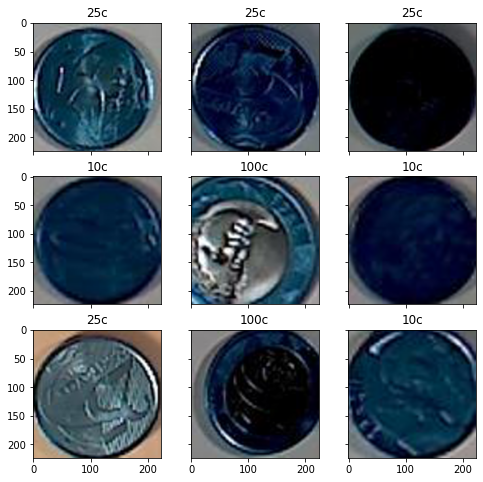

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), 
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,300))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), 
          title=img_label,plt_ax=fig_x)

Import ResNet50 pretrained on ImageNet for transfer learning. Freeze 1-3 layers and replace the classifier of the model to train only 4 and fully-connected layers

In [ ]:
import torchvision.models as models

In [ ]:
model_1 = models.resnet50(pretrained=True)

# замораживаем параметры (веса)
for param in model_1.parameters():
    param.requires_grad = False
for param in model_1.layer4.parameters():
    param.requires_grad = True  

model_1.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 5)
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    if scheduler is not None:
        scheduler.step()
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
    

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import AdamW

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = AdamW(model.parameters(), lr=0.0005)
        scheduler = ExponentialLR(optimizer=opt, gamma=0.85)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

We will classify 5 classes: 5, 10, 25, 50, 100 coins

In [ ]:
#n_classes = len(np.unique(train_labels))
my_cnn_1 = model_1.to(DEVICE)
print("we will classify :{}".format(5))
print(my_cnn_1)

we will classify :5
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

In [ ]:
if val_dataset is None:
    val_dataset = CoinsDataset(val_files, mode='val')
    
train_dataset = CoinsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=my_cnn_1, epochs=20, batch_size=48)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.46752534890261094


epoch:   5%|▌         | 1/20 [00:17<05:34, 17.61s/it]


Epoch 001 train_loss: 0.4675     val_loss 0.4888 train_acc 0.8354 val_acc 0.8692
loss 0.7452833713933313


epoch:  10%|█         | 2/20 [00:34<05:15, 17.52s/it]


Epoch 002 train_loss: 0.7453     val_loss 0.6107 train_acc 0.7227 val_acc 0.8029
loss 0.30873997415168375


epoch:  15%|█▌        | 3/20 [00:52<04:57, 17.51s/it]


Epoch 003 train_loss: 0.3087     val_loss 0.5486 train_acc 0.9005 val_acc 0.7845
loss 0.193808690781215


epoch:  20%|██        | 4/20 [01:09<04:40, 17.52s/it]


Epoch 004 train_loss: 0.1938     val_loss 0.2562 train_acc 0.9343 val_acc 0.9171
loss 0.14964833539012976


epoch:  25%|██▌       | 5/20 [01:27<04:22, 17.51s/it]


Epoch 005 train_loss: 0.1496     val_loss 0.2289 train_acc 0.9542 val_acc 0.9153
loss 0.10722316312814169


epoch:  30%|███       | 6/20 [01:45<04:05, 17.56s/it]


Epoch 006 train_loss: 0.1072     val_loss 0.2288 train_acc 0.9656 val_acc 0.9374
loss 0.10847639801758754


epoch:  35%|███▌      | 7/20 [02:02<03:48, 17.61s/it]


Epoch 007 train_loss: 0.1085     val_loss 0.2672 train_acc 0.9675 val_acc 0.9190
loss 0.1448988717244719


epoch:  40%|████      | 8/20 [02:20<03:31, 17.59s/it]


Epoch 008 train_loss: 0.1449     val_loss 0.2446 train_acc 0.9506 val_acc 0.9171
loss 0.1208135065560315


epoch:  45%|████▌     | 9/20 [02:38<03:13, 17.61s/it]


Epoch 009 train_loss: 0.1208     val_loss 0.1972 train_acc 0.9584 val_acc 0.9319
loss 0.08649401748670807


epoch:  50%|█████     | 10/20 [02:55<02:56, 17.68s/it]


Epoch 010 train_loss: 0.0865     val_loss 0.2506 train_acc 0.9717 val_acc 0.9282
loss 0.08860322787252947


epoch:  55%|█████▌    | 11/20 [03:13<02:39, 17.67s/it]


Epoch 011 train_loss: 0.0886     val_loss 0.1925 train_acc 0.9711 val_acc 0.9411
loss 0.07397516136972156


epoch:  60%|██████    | 12/20 [03:31<02:21, 17.66s/it]


Epoch 012 train_loss: 0.0740     val_loss 0.1967 train_acc 0.9753 val_acc 0.9503
loss 0.0663497638055014


epoch:  65%|██████▌   | 13/20 [03:49<02:04, 17.73s/it]


Epoch 013 train_loss: 0.0663     val_loss 0.2095 train_acc 0.9783 val_acc 0.9429
loss 0.05651649579937969


epoch:  70%|███████   | 14/20 [04:06<01:46, 17.74s/it]


Epoch 014 train_loss: 0.0565     val_loss 0.2118 train_acc 0.9789 val_acc 0.9337
loss 0.05786178919535541


epoch:  75%|███████▌  | 15/20 [04:24<01:28, 17.79s/it]


Epoch 015 train_loss: 0.0579     val_loss 0.2074 train_acc 0.9819 val_acc 0.9411
loss 0.052645702203011534


epoch:  80%|████████  | 16/20 [04:42<01:11, 17.81s/it]


Epoch 016 train_loss: 0.0526     val_loss 0.2067 train_acc 0.9807 val_acc 0.9392
loss 0.04652159642866033


epoch:  85%|████████▌ | 17/20 [05:00<00:53, 17.85s/it]


Epoch 017 train_loss: 0.0465     val_loss 0.2177 train_acc 0.9819 val_acc 0.9429
loss 0.046134612656065395


epoch:  90%|█████████ | 18/20 [05:18<00:35, 17.83s/it]


Epoch 018 train_loss: 0.0461     val_loss 0.2088 train_acc 0.9819 val_acc 0.9466
loss 0.048974685424814174


epoch:  95%|█████████▌| 19/20 [05:36<00:17, 17.85s/it]


Epoch 019 train_loss: 0.0490     val_loss 0.2088 train_acc 0.9825 val_acc 0.9503
loss 0.046514228148012


epoch: 100%|██████████| 20/20 [05:54<00:00, 17.72s/it]


Epoch 020 train_loss: 0.0465     val_loss 0.1969 train_acc 0.9843 val_acc 0.9466


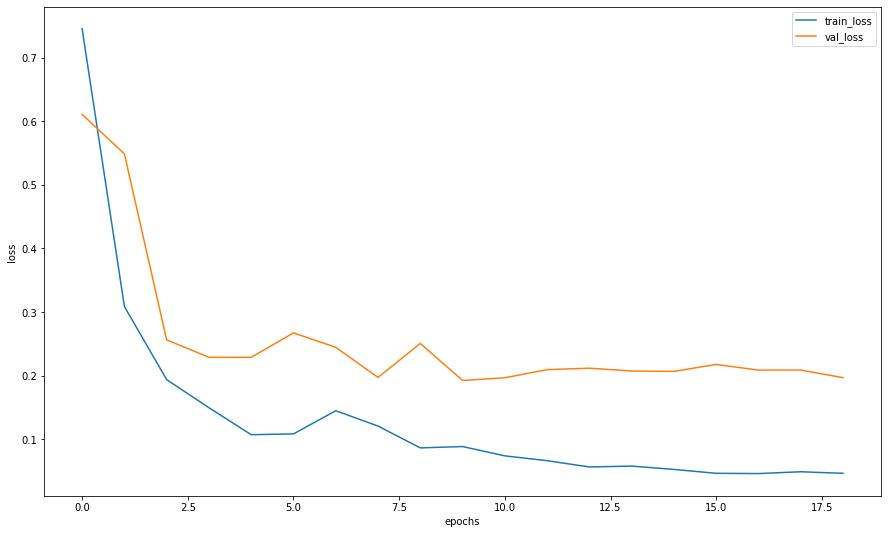

In [ ]:
plt.figure(figsize=(15, 9))
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss[1::], label="train_loss")
plt.plot(val_loss[1::], label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

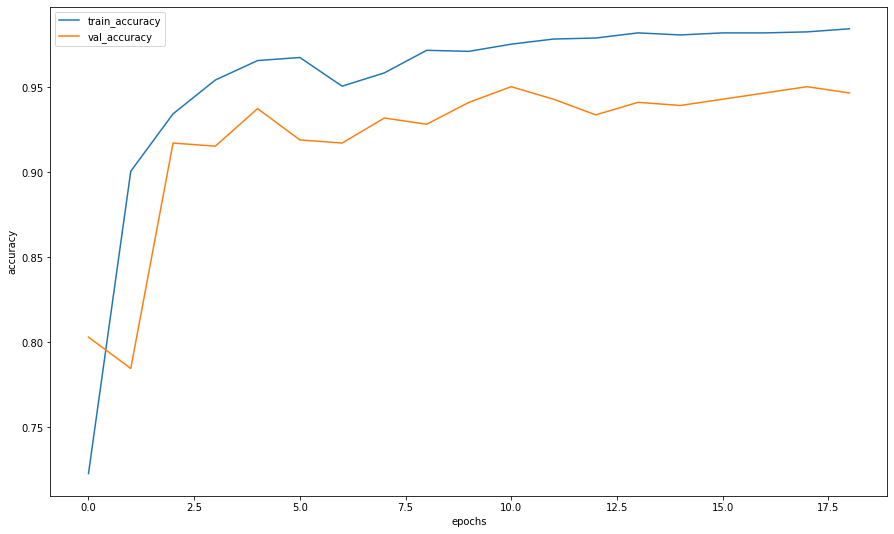

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc[1::], label="train_accuracy")
plt.plot(val_acc[1::], label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
history = train(train_dataset, val_dataset, model=my_cnn_1, epochs=7, batch_size=64)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 3.436624453181312


epoch:  14%|█▍        | 1/7 [00:13<01:20, 13.36s/it]


Epoch 001 train_loss: 3.4366     val_loss 1.5283 train_acc 0.3406 val_acc 0.2634
loss 1.1747743592986577


epoch:  29%|██▊       | 2/7 [00:26<01:06, 13.39s/it]


Epoch 002 train_loss: 1.1748     val_loss 1.1977 train_acc 0.4955 val_acc 0.4457
loss 0.8213282619131984


epoch:  43%|████▎     | 3/7 [00:40<00:53, 13.48s/it]


Epoch 003 train_loss: 0.8213     val_loss 0.7482 train_acc 0.6335 val_acc 0.6943
loss 0.5921709606847252


epoch:  57%|█████▋    | 4/7 [00:54<00:40, 13.57s/it]


Epoch 004 train_loss: 0.5922     val_loss 0.7972 train_acc 0.7547 val_acc 0.6832
loss 0.6358956117957669


epoch:  71%|███████▏  | 5/7 [01:07<00:27, 13.57s/it]


Epoch 005 train_loss: 0.6359     val_loss 0.7192 train_acc 0.7215 val_acc 0.7127
loss 0.4666599880290937


epoch:  86%|████████▌ | 6/7 [01:21<00:13, 13.53s/it]


Epoch 006 train_loss: 0.4667     val_loss 0.6085 train_acc 0.8131 val_acc 0.7569
loss 0.32942640458948286


epoch: 100%|██████████| 7/7 [01:34<00:00, 13.54s/it]


Epoch 007 train_loss: 0.3294     val_loss 0.4808 train_acc 0.8843 val_acc 0.8508


Saving weights of the model not to train classifier later. Accuracy reached 0.9861 for train images and 0.9511 for test images

In [ ]:
Path = ("my_model.pt")
torch.save(my_cnn_1, Path)

Dowloading weights

In [ ]:
Path = ("brazilian_model.pt")

In [ ]:
Path = ("my_model.pt")

In [ ]:
model = torch.load(Path)
model.eval()

In [ ]:
#training 4 and fc layers
plt.figure(figsize=(15, 9))
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
# precision for 1 picture
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

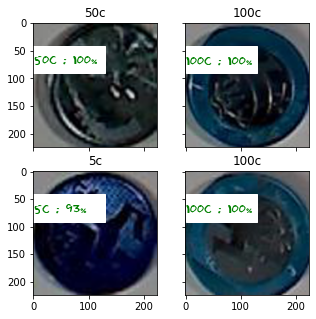

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(5, 5),
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 41),130,50,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn_1, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=13, color='green',fontweight='bold')

Prediction for 1 picture

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

Detection

In [ ]:
import numpy as np
import cv2

In [ ]:
image = cv2.imread("9.jpg")

In [ ]:
image = cv2.imread("95_1477857912.jpg")

Make copy of image to show results of detection on it

In [ ]:
output = image.copy()

Convert image to grayscale and blurring it

In [ ]:
gray_im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_im, (3, 3), 1)

In [ ]:
clf = model

In [ ]:
diameter = []
materials = []
coordinates = []

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image

Detecting circles by cv2.HoughCircles. Parameters of the function were found specially for the dataset in the single part of project

In [ ]:
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.2, 20, param2=70, minRadius = 27)

In [ ]:
from pathlib import Path

In [ ]:
count = 0
if circles is not None:
    # append radius to list of diameters 
    for (x, y, r) in circles[0, :]:
        diameter.append(r)

    # convert to integers
    circles = np.round(circles[0, :]).astype("int")

    # for each detected coin add coordinates of its center to list, extract ROI 
    # and save it to the coins folder like a single image
    for (x, y, d) in circles:
        count += 1

        coordinates.append((x, y))

        roi = image[y - d:y + d, x - d:x + d]
        path = 'coins/' + str(count) + '.jpg'
        roi_im = Image.fromarray(roi)   
        roi_im.save(path) 
        
        VAL_DIR = Path('coins')
        val_files = sorted(list(VAL_DIR.rglob('*.jpg')))
        val_dataset = CoinsDataset(val_files, "val")
        
        #cv2_imshow(roi)
        if count == 10:
            break
        print(count)

1
2
3
4
5
6
7


In [ ]:
labels = []
classes_dict = {'5c': 5, '10c': 10, '25c': 25, '50c': 50, '100c': 100}

In [ ]:
print(coordinates)

[(386, 124), (311, 334), (230, 255)]


Classification of coins on ROI

In [ ]:
VAL_DIR = Path('coins')
val_files = sorted(list(VAL_DIR.rglob('*.jpg')))
print(val_files)
val_dataset = CoinsDataset(val_files, "val")

for i in range(count):

    im, label = val_dataset[i]
    prob_pred = predict_one_sample(clf, im.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    labels.append(predicted_label)
    print(predicted_label)

Summarize precisions and showing the output of model

In [ ]:
print(labels)

In [ ]:
def count_sum(labels, classes_dict):
    total = 0
    for item in labels:
        total += classes_dict[str(item)]
    return total

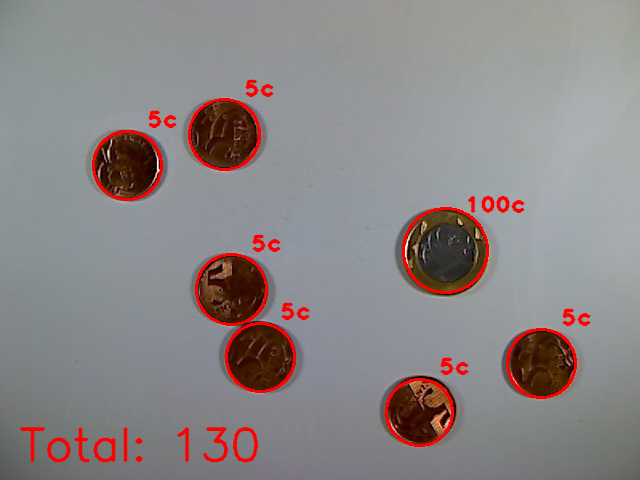

In [ ]:
for i in range(len(labels)):
    d = diameter[i]
    (x, y) = coordinates[i]
    cv2.circle(output, (x, y), d, (0, 0, 255), 2)
    cv2.putText(output, labels[i],
                    (x + 20, y - 38), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
total = count_sum(labels, classes_dict)
answer = 'Total: ' + str(130)
cv2.putText(output, answer, (20, 460), cv2.FONT_HERSHEY_SIMPLEX,
           1.5, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
cv2_imshow(output)



In [ ]:
import pandas as pd
df_confusion = pd.crosstab(y_act, y_pred)
df_confusion.head()

Predicted labels,100c,10c,25c,50c,5c
Actual labels,,,,,
100c,46,2,0,0,0
10c,2,52,0,0,2
25c,0,0,99,0,6
50c,0,0,0,88,13
5c,0,0,8,13,109


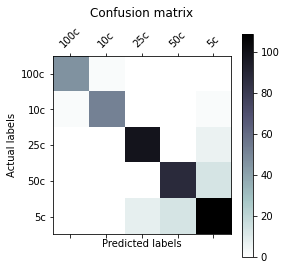

In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.bone_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title('Confusion matrix', pad=30)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)